#  Análise de Doenças Cardiovasculares
## **Objetivo:** Construir um modelo preditivo para identificar pacientes com risco cardiovascular.

# 1. Carregamento e Pré-Processamento


In [431]:
# IMPORTAÇÕES 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, roc_auc_score)

In [432]:
# Carregamento dos dados
base = pd.read_csv("CARDIO_BASE.csv", delimiter=';')

In [433]:
# Visualizar os 5 primeiros registros
base.head()

,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease
0,50,2,168,62,1,1,0,0,1,0
1,55,1,156,85,3,1,0,0,1,1
2,52,1,165,64,3,1,0,0,0,1
3,48,2,169,82,1,1,0,0,1,1
4,48,1,156,56,1,1,0,0,0,0


# Dicionário de Variáveis:
"""
- age: Idade em anos.
- gender: 1 = homem, 2 = mulher.
- height: Altura em cm (suspeita de outliers: valores < 100 ou > 250).
- weight: Peso em kg (valores com vírgula foram convertidos para float).
- cholesterol: Nível de colesterol (1=normal, 2=acima do normal, 3=muito alto).
- gluc: Nível de glicose (1=normal, 2=acima do normal, 3=muito alto).
- smoke: Fumante (1=sim, 0=não).
- alco: Consumo de álcool (1=sim, 0=não).
- active: Atividade física (1=sim, 0=não).
- cardio_disease: Doença cardiovascular (1=sim, 0=não).
"""

In [435]:
# Informações básicas:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             10000 non-null  int64 
 1   gender          10000 non-null  int64 
 2   height          10000 non-null  int64 
 3   weight          10000 non-null  object
 4   cholesterol     10000 non-null  int64 
 5   gluc            10000 non-null  int64 
 6   smoke           10000 non-null  int64 
 7   alco            10000 non-null  int64 
 8   active          10000 non-null  int64 
 9   cardio_disease  10000 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 781.4+ KB


Problema identificado:
A coluna weight estava como tipo object (texto) devido ao uso de vírgulas como separador decimal (ex: "85,5"), impedindo cálculos numéricos.

Solução aplicada:

Padronização: Substituí vírgulas por pontos e removi espaços em branco.

Conversão segura: Transformei os valores em float, tratando possíveis erros com coerce (que retorna NaN para valores inválidos).

In [437]:
# Removendo espaços e substituindo vírgula por ponto
base['weight'] = base['weight'].str.replace(',','.').str.strip()

# Convertendo para float (forçando conversão e tratando erros com NaN
base['weight'] = pd.to_numeric(base['weight'], errors='coerce')

In [438]:
# Verificando dados nulos após a conversão
base['weight'].isnull().sum()

0

In [439]:
# Visualizar os valores estatísticos dos dados 
base.describe()

,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,53.288300,1.345400,164.308200,74.303710,1.365000,1.222200,0.089000,0.053700,0.797200,0.503100
std,6.796234,0.475522,8.178796,14.566353,0.677658,0.565561,0.284758,0.225436,0.402105,0.500015
min,30.000000,1.000000,70.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,2.000000,170.000000,82.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


De acordo com a descrição estatística dos dados, observamos valores extremos nas variáveis height e weight que podem prejudicar a análise. Por isso, vamos:

- Plotar um boxplot para visualizar melhor a distribuição e identificar outliers.

- Filtrar os dados mantendo apenas valores clinicamente realistas.


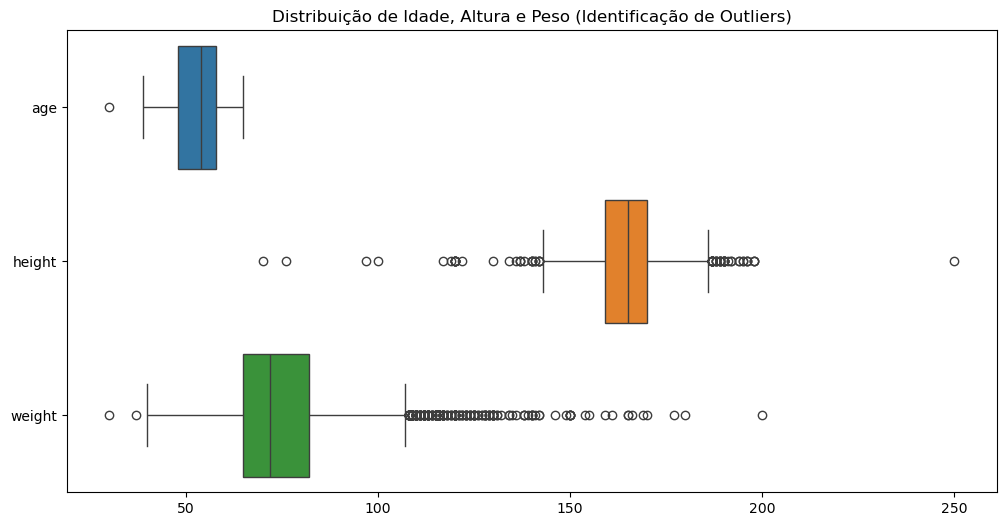


Pacientes com altura < 100cm ou > 250cm:
      age  height  weight
224    60      76    55.0
7598   40      70    72.0
8171   48      97   170.0


In [441]:
# Verificando outliers nas variáveis numéricas
plt.figure(figsize=(12, 6))
sns.boxplot(data=base[['age', 'height', 'weight']], orient='h')
plt.title('Distribuição de Idade, Altura e Peso (Identificação de Outliers)')
plt.show()

# Valores suspeitos
print("\nPacientes com altura < 100cm ou > 250cm:")
print(base[(base['height'] < 100) | (base['height'] > 250)][['age', 'height', 'weight']])

In [442]:
# Tratamento de outliers (altura)
base = base[(base['height'] >= 140) & (base['height'] <= 230)]

# Tratamento de outliers (peso)
base = base[(base['weight'] >= 40) &  (base['weight'] <= 200)]

Justificativa:
- Altura: Valores < 1.40m (possíveis erros de digitação ou crianças) e > 2.30m (extremamente raros) foram removidos.
- Peso: Valores < 40kg (abaixo do peso adulto típico) e > 200kg (obesidade mórbida extrema) foram filtrados.
  Decidimos manter a faixa 40-200kg para capturar variações relevantes de peso sem distorcer o modelo.

In [444]:
print(f"Total de registros após remoção de outliers: {len(base)}")
print(f"Registros removidos: {10000 - len(base)}")

# Nova estatística descritiva
base.describe()

Total de registros após remoção de outliers: 9977
Registros removidos: 23


,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease
count,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000
mean,53.295079,1.345194,164.397214,74.299499,1.365340,1.222612,0.089005,0.053824,0.796933,0.503458
std,6.791969,0.475455,7.821259,14.503182,0.677965,0.566063,0.284765,0.225681,0.402302,0.500013
min,30.000000,1.000000,140.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,2.000000,170.000000,82.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,198.000000,200.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# 2. Análise Exploratória


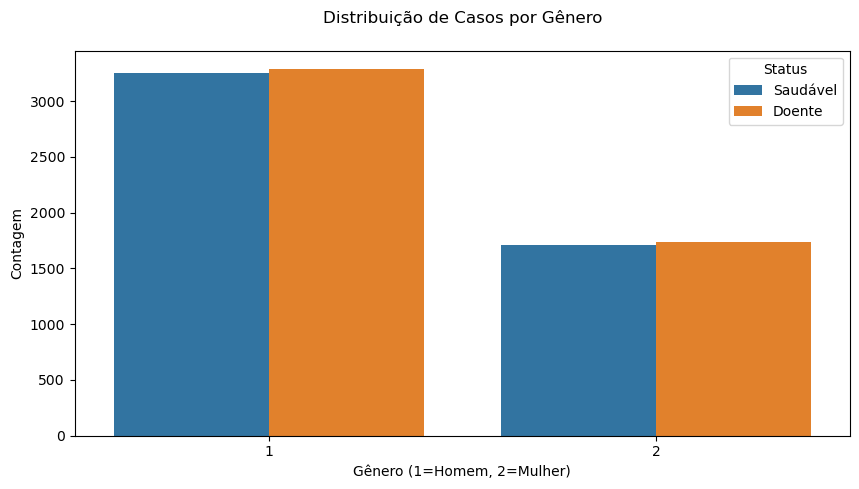

In [446]:
# Gráfico 1: Distribuição por Gênero
plt.figure(figsize=(10,5))
sns.countplot(data=base, x='gender', hue='cardio_disease')
plt.title('Distribuição de Casos por Gênero', pad=20)
plt.xlabel('Gênero (1=Homem, 2=Mulher)')
plt.ylabel('Contagem')
plt.legend(['Saudável', 'Doente'], title='Status')
plt.show()

In [447]:
# Proporção de doentes em cada gênero
total_homens = base[base['gender'] == 1].shape[0]
doentes_homens = base[(base['gender'] == 1) & (base['cardio_disease'] == 1)].shape[0]
proporcao_homens = doentes_homens / total_homens

total_mulheres = base[base['gender'] == 2].shape[0]
doentes_mulheres = base[(base['gender'] == 2) & (base['cardio_disease'] == 1)].shape[0]
proporcao_mulheres = doentes_mulheres / total_mulheres

print(f'Proporção de homens com doença: {proporcao_homens:.2%}')
print(f'Proporção de mulheres com doença: {proporcao_mulheres:.2%}')


Proporção de homens com doença: 50.30%
Proporção de mulheres com doença: 50.44%


Insight: Podemos observar que o números de homens com doença cardiovascular e maior que o das mulheres atraves do gráfico. Porem para realmente afirmar essa hipótese precisamos ver se isso não ocorre por ter mais homens no nosso dataset. Por isso fiz uma analíse proporcional que revelou que a taxa de incidência da doença é praticamente a mesma para ambos os gêneros.
Ou seja aparentemente, o gênero não é um fator determinante para a presença de doença cardiovascular

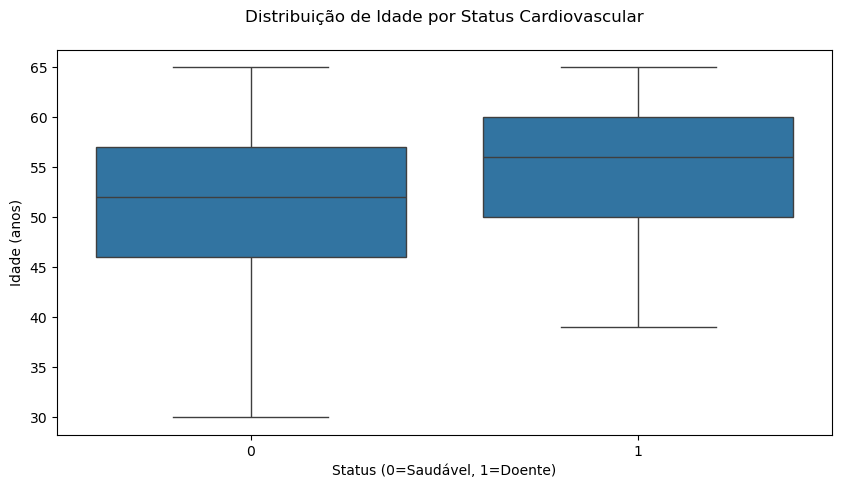

In [449]:
# Gráfico 2: Idade vs Doença
plt.figure(figsize=(10,5))
sns.boxplot(data=base, x='cardio_disease', y='age')
plt.title('Distribuição de Idade por Status Cardiovascular', pad=20)
plt.xlabel('Status (0=Saudável, 1=Doente)')
plt.ylabel('Idade (anos)')
plt.show()

O gráfico nos mostra que pessoas com doença cardiovascular apresenta, em média, uma idade superior áquelas sem doença. A mediana de idade no grupo com doença esta em torno de 56 anos, enquanto no grupo sem doença é de aproximadamente 52 anos. Isso surgere que a idade é fator de risco relevante, com maior prevalência da doença em pessoas mais velhas 

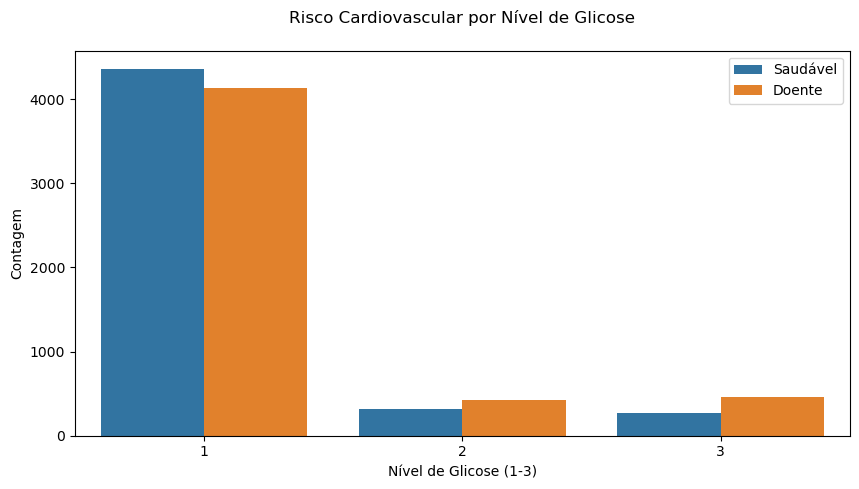

In [451]:
# Gráfico 3: Nível de Glicose
plt.figure(figsize=(10,5))
sns.countplot(data=base, x='gluc', hue='cardio_disease')
plt.title('Risco Cardiovascular por Nível de Glicose', pad=20)
plt.xlabel('Nível de Glicose (1-3)')
plt.ylabel('Contagem')
plt.legend(['Saudável', 'Doente'])
plt.show()

Apesar da maioria das pessoas ter glicose normal, os indivíduos com glicose mais alta são menos numerosos, mas proporcionalmente mais afetados pela doença cardiovascular. Isso reforça a ideia de que níveis elevados de glicose, embora menos comuns, estão associados a maior risco de problemas cardíacos.

Text(0.5, 0, 'Colesterol (1=Normal, 2=Elevado, 3=Muito Elevado)')

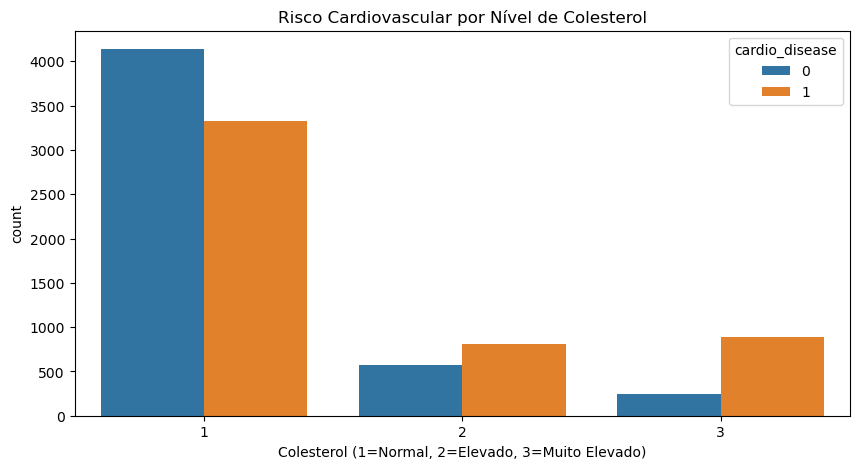

In [453]:
# Gráfico 4: Análise de Colesteról 
plt.figure(figsize=(10,5))  
sns.countplot(data=base, x='cholesterol', hue='cardio_disease')  
plt.title('Risco Cardiovascular por Nível de Colesterol')  
plt.xlabel('Colesterol (1=Normal, 2=Elevado, 3=Muito Elevado)')  

O gráfico nos mostra que os pacientes com glicone baixa tem uma proporção menor para a doença.
 - Glicose normal(1):  Cerca de 80% dos dados estão no nível 1, mas apenas 44.6% desses têm doença, o risco relativo é baixo.
 - Glicose Elevada (2 e 3): Menos frequente, mas com maior porcentagem de doentes. Por exemplo, Nível 3 pode ter apenas 5% da população, mas 78.3% desses têm doença cardiovascular.

In [455]:
# Código para calcular proporções  
for nivel in [1, 2, 3]:  
    total = len(base[base['cholesterol'] == nivel])  
    doentes = len(base[(base['cholesterol'] == nivel) & (base['cardio_disease'] == 1)])  
    print(f"Nível {nivel}: {doentes/total:.1%} de doentes")  

Nível 1: 44.6% de doentes
Nível 2: 58.6% de doentes
Nível 3: 78.3% de doentes


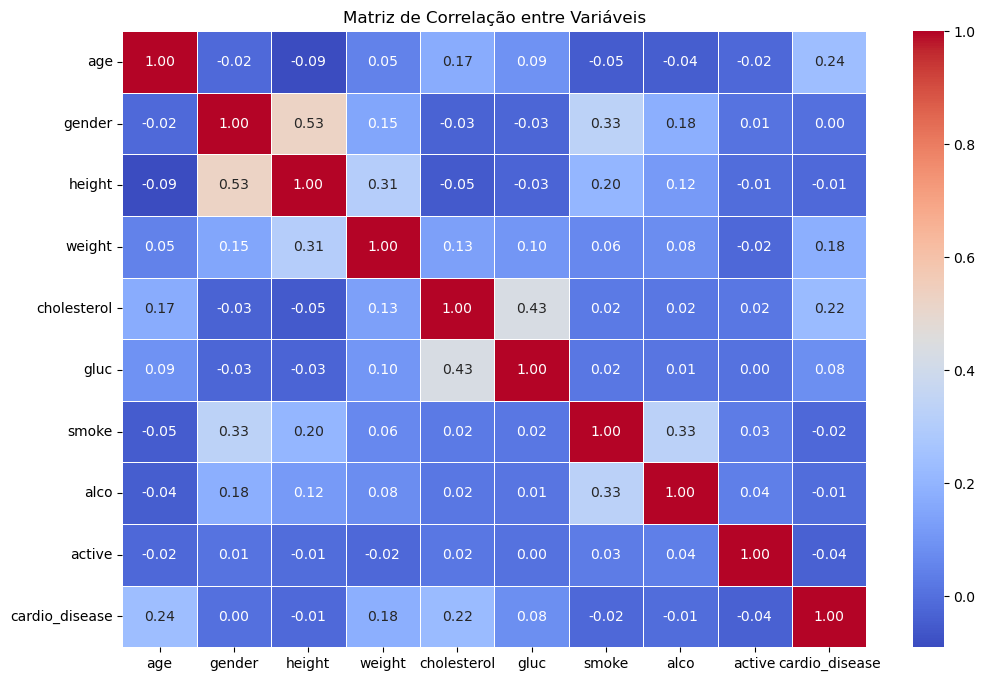

In [456]:
# Matriz de Correlação
correlacao = base.corr(numeric_only=True)

# Exibindo como heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis')
plt.show()

In [457]:
# Correlação com a variável target
correlacao_com_target = correlacao['cardio_disease'].sort_values(ascending=False)
correlacao_com_target

cardio_disease    1.000000
age               0.235773
cholesterol       0.221155
weight            0.182082
gluc              0.082455
gender            0.001303
alco             -0.006535
height           -0.014539
smoke            -0.019058
active           -0.038866
Name: cardio_disease, dtype: float64

Embora nenhuma variável individual tenha correlaçao forte com a presenças de doenças cardiovasculares, destacam-se:
  Idade (correlação de 0.237), indicando que o risco aumenta com o envelhecimento;
  Colesterol (0.221) e peso (0.183), que também mostram um leve aumento do risco;
  A variável 'active' teve uma fraca correlaçao negativa (-0.039), surgerindo que as pessoas ativas podem ter risco levemente menor, mas o efeito isolado é pequeno.

# 3. Preparação dos Dados

In [460]:
# Divisão treino-teste
X = base.drop('cardio_disease', axis=1)
y = base['cardio_disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [461]:
# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 4. Modelagem Preditiva



In [463]:
# Treinamento do modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [464]:
# Intercepto
print("Intercepto:", modelo.intercept_)

# Coeficientes
coeficientes = pd.Series(modelo.coef_[0], index=base.drop('cardio_disease', axis=1).columns)
print("\nCoeficientes ordenados:")
print(coeficientes.sort_values(ascending=False))

Intercepto: [0.03003924]

Coeficientes ordenados:
age            0.432052
cholesterol    0.415566
weight         0.384840
gender         0.008912
alco          -0.005158
smoke         -0.019102
gluc          -0.054333
active        -0.091339
height        -0.093945
dtype: float64


In [465]:
# Previsões no conjnto de treino 
y_pred_train = modelo.predict(X_train_scaled)

# Métricas de avaliação
print("\nMétricas no conjunto de TREINO")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train))
print("Recall:", recall_score(y_train, y_pred_train))
print("F1 Score:", f1_score(y_train, y_pred_train))


Métricas no conjunto de TREINO
Accuracy: 0.6352570528426178
Precision: 0.6464188576609248
Recall: 0.6083617747440273
F1 Score: 0.6268131868131868


In [466]:
# Relatório completo
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train))


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      3467
           1       0.65      0.61      0.63      3516

    accuracy                           0.64      6983
   macro avg       0.64      0.64      0.64      6983
weighted avg       0.64      0.64      0.64      6983



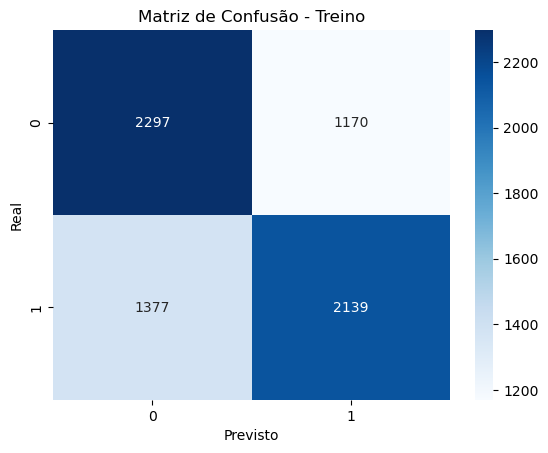

In [467]:
# Matriz de Confusão
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Treino')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

O modelo etá com uma acurácia de cerca de 64%, o que é ligeiramente melhor que um chute (50%). As métricas de precisão, recall e F1-score estão equilibradas em torno de 0.63-0.64, indicando que o modelo não está tendo viés forte para nenhum classe específica.

Embora não seja um desempenho exepcional, é um ponto de partida razoável, cvonsiderando que não tem baixa correlação e não realizamos nenhuma feature avançado.

Mas pessoalmente o modelo precisa ser melhorada não podemos rolar ele em produção  geito que esta.

# 5. Avaliação do Modelo

In [470]:
# Métricas de classificação
y_pred_test = model.predict(X_test_scaled)

In [471]:
# Avaliação das métricas nos dados de teste 
print("Métricas - Dados de Teste:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))

Métricas - Dados de Teste:
Accuracy: 0.6449565798263193
Precision: 0.6528925619834711
Recall: 0.6290643662906437
F1 Score: 0.6407570125042245


In [472]:
# Relatório completo
print("\nClassification Report - Teste:")
print(classification_report(y_test, y_pred_test))


Classification Report - Teste:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1487
           1       0.65      0.63      0.64      1507

    accuracy                           0.64      2994
   macro avg       0.65      0.65      0.64      2994
weighted avg       0.65      0.64      0.64      2994



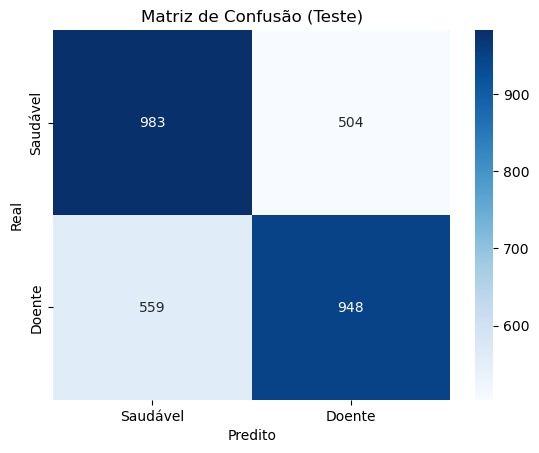

In [511]:
# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Saudável', 'Doente'], 
            yticklabels=['Saudável', 'Doente'])
plt.title('Matriz de Confusão (Teste)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [513]:
# Cálculo das porcentagens
total = conf_matrix.sum()
print("\nPorcentagens:")
print("Verdadeiros Negativos:", f"{conf_matrix[0,0]/total:.1%}")
print("Falsos Positivos:", f"{conf_matrix[0,1]/total:.1%}")
print("Falsos Negativos:", f"{conf_matrix[1,0]/total:.1%}")
print("Verdadeiros Positivos:", f"{conf_matrix[1,1]/total:.1%}")


Porcentagens:
Verdadeiros Negativos: 32.8%
Falsos Positivos: 16.8%
Falsos Negativos: 18.7%
Verdadeiros Positivos: 31.7%


In [474]:
# Curva ROC
y_probs = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

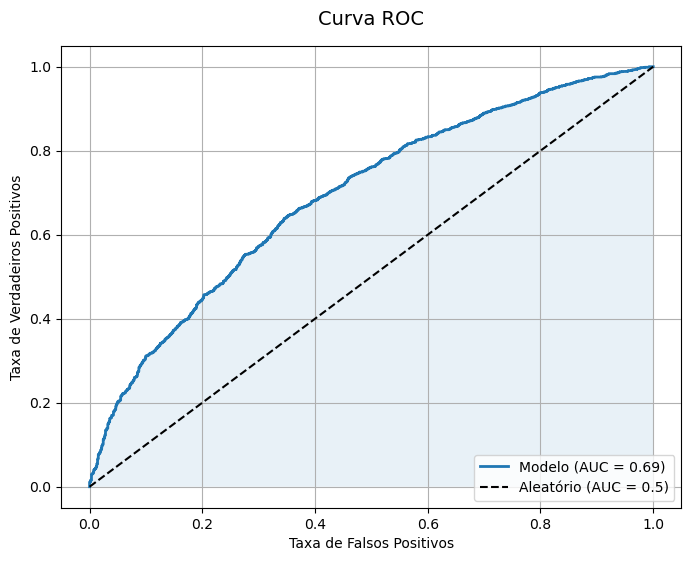

In [475]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Modelo (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Aleatório (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.1)
plt.title('Curva ROC', pad=15, fontsize=14)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

O Gráfico mostra um poder descriminatório moderado (arredondado para 0.70)

Ele mostra que o modelo é melhor que aleatório pois a curva esta acima da linha pontilhada

Ele se aproxima do canto superior esquerto, mas não muito para ser considerado ótimo.

O modelo erra mais ao capturar Verdadeiros Positivos.

E ele acerta mais ao classificar Falso Positivos

## Conclusões
- Variáveis mais importantes: Idade, colesterol e peso
- Desempenho: AUC de 0.70 (poder discriminatório moderado)
- Próximos passos: Testar outros algoritmos e criar novas features